# TOP

In [ ]:
# full screen width of Jupyter notebook
from IPython.display import display, HTML
display(HTML("<style>.container {width:90%;} </style>")) 
display(HTML("<style>.toc{ margin-top: 100px;} </style>"))

In [2]:
import os
os.environ['rz_token'] = '5bc2502a20241231'

In [3]:
import os
os.chdir('../../')
print(f'[+] cwd = {os.getcwd()}, __file__ = {__file__ if "__file__" in vars() else None}')

import sys
sys.path.insert(0, os.path.abspath('./'))
import lightgbm as lgb
import json
import os
import runningz as rz
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from runningz.fe.util.util import subsample
from runningz.fe.prepare_data.basic_data import *
from runningz.fe.er import Typer
from runningz.util.clss import get_subclass_by_name
from runningz.util.const import CONST
from runningz.util.util import my_print as print
from runningz.util.util import dict_2_str
from runningz.core.op import show_op_dict
from runningz.fe.config.fm_config import fm_config_list_ALL, data_config
from runningz.fe.util.util import print_history
rz.seed_everything(42)
OP_DICT, OP_DICT_NOT, OP_DICT_YES = show_op_dict()
CONST.DEBUG = False
CONST.MY_PRINT = False

[+] cwd = /Users/runningz/project/runningz, __file__ = None
[+] len(fm_config_list_TOP) = 18
[+] len(fm_config_list_OPT) = 100
[RZ][11:33:10] runningz/core/op/__init__.py:218-> [+] OP_DICT      = 377
[RZ][11:33:10] runningz/core/op/__init__.py:219-> [+] OP_DICT_NOT  = 100
[RZ][11:33:10] runningz/core/op/__init__.py:220-> [+] OP_DICT_YES  = 277
[RZ][11:33:10] runningz/core/op/__init__.py:220-> x             0
[RZ][11:33:10] runningz/core/op/__init__.py:220-> roll         10
[RZ][11:33:10] runningz/core/op/__init__.py:220-> agg          24
[RZ][11:33:10] runningz/core/op/__init__.py:220-> gp           19
[RZ][11:33:10] runningz/core/op/__init__.py:220-> roll_2       12
[RZ][11:33:10] runningz/core/op/__init__.py:220-> agg_2         9
[RZ][11:33:10] runningz/core/op/__init__.py:220-> gp_2          9
[RZ][11:33:10] runningz/core/op/__init__.py:220-> merge         5
[RZ][11:33:10] runningz/core/op/__init__.py:220-> op_1         13
[RZ][11:33:10] runningz/core/op/__init__.py:220-> op_1_v    

In [ ]:
sys.argv = 'fe_main.py --task DEBUG --label twap 0 1'.split(' ')

In [1]:
import argparse
parser = argparse.ArgumentParser()
parser.add_argument('--task', type=str, default='DEBUG')  # str
parser.add_argument('--label', nargs=3, default=['vwap', 0, 1], help='help info') # any number of
parser.add_argument('--debug', nargs='*', default=None, help='help info') # any number of
args = parser.parse_args()
print(f'[+] args = {args}')

CONST.DEBUG = (type(args.debug) is list)
task = args.task
data_config.other_info.col_label_args  = args.label
data_config.other_info.col_label_shift = f'{args.label[0]}_ret'
# data_config.other_info.col_label_from  = 'LABEL_{}_{}_{}'.format(*args.label)

# path_output
date = rz.time_str()[:10].replace('/', '')
path_output = f'runningz/fe/_cache_/{date}/'
os.makedirs(path_output, exist_ok = True)
# import IPython; IPython.embed()

# ------------------------------ read ------------------------------
# read data
print(dict_2_str(data_config))
# rz.dump_json(data_config, f'{path_output}/{task}.data_config')        
dm = get_subclass_by_name(BaseData, data_config.data_reader)().load(data_config)
print('[init] <---------- mask_ALL  ----------> ')
dm.set_mask_ALL(verbose = True) # for multi predict
print(f'[+] dm.shape() = {dm.shape()}')
if CONST.DEBUG: 
    print('[init] <---------- subsample  ---------> ')
    subsample(dm, pct = 0.1)
    print(f'[+] dm.shape() = {dm.shape()}')

# ------------------------------ cols_dict_init ------------------------------
col_id = data_config.cols_dict.col_id
col_date = data_config.other_info.col_date
col_label = data_config.cols_dict.col_label
cols_tid = data_config.cols_dict.cols_tid
col_label_shift = data_config.other_info.col_label_shift
col_tid = data_config.cols_dict.col_tid

cols_dict_init = {}
history = []
path = None
if path is not None:
    cols_dict_init = rz.load_json(path)
    history = rz.load_json(f'{path[:-5]}.history')
    print(f'[+] cache, dict = ')
    print(pd.Series(cols_dict_init).apply(len).to_string())
    print(f'[+] cache, history = ')
    print_history(history)

# ---------- basic ----------
print('[init] <---------- fe_basic  ----------> ')
dm.fe_go(cols_dict_init.get('name_list_basic', []))
dm.fe_go(cols_dict_init.get('cols_fea', []))
name_list_basic = []
name_list = [
    f'date_int = int32({col_date})',
    f'date_t = to_datetime({col_date})',
    f'ts = timestamp(date_t)',
    f'dow = dow(date_t)',
    f'x({col_id}, dow)',
    f'is_holiday = holiday(date_t)',
    f'ndays = days_diff(date_t, 2010-01-01)',
    
    f'date_shift_1 = roll(shift, {col_id}, {col_date}, {col_tid}, 1)',
    f'date_diff_1 = dif({col_date}, date_shift_1)',
    
    f'date_shift_m1 = roll(shift, {col_id}, {col_date}, {col_tid}, -1)',
    f'date_diff_m1 = dif({col_date}, date_shift_m1)',
    
    f'y_shift_1 = roll(shift, {col_id}, {col_label_shift}, {col_tid}, 1)',
    f'y_shift_2 = roll(shift, {col_id}, {col_label_shift}, {col_tid}, 2)',
    f'y_shift_3 = roll(shift, {col_id}, {col_label_shift}, {col_tid}, 3)',
]
dm.fe_go(name_list)
name_list_basic += name_list
cols_fix = []
cols_dict_init['cols_fix'] = cols_fix

# ------------------------------ cache ------------------------------
typer_config = {
    **dict(data_config.cols_dict),
    'cols_num': [],
    'cols_cat': [col_id, col_tid, f'x({col_id}, dow)'] +  (cols_tid if len(cols_tid) != 1 else []),
    'cols_datetime': ['date_t'],
    'cols_timestamp': ['ts'],
    'cols_fix': cols_fix,
    'name_list_basic': name_list_basic,
    'cols_fea': [],
}
typer_config['data_config'] = dict(data_config)
typer_config = {**typer_config, **cols_dict_init}  # insert data_config into cols_dict
typer = Typer(typer_config)
typer.update_cols_num(dm.head().columns)
print('[init] <---------- typer_config ----------> ')
print(pd.Series(typer.typer_config).apply(len).to_string())
# import IPython; IPython.embed()

# # ------------------------------ go ------------------------------
fm_config_list = fm_config_list_ALL
fm = rz.fe.FEMaster(dm, typer, history)
# for i, fm_config in tqdm(enumerate(fm_config_list)):
#     # if i <= 76: continue

#     time_str = rz.time_str(fmt = '%Y%m%d_%H%M%S')
#     print(f'{">>" * 50}, fm_config_i = {i:02d} / {len(fm_config_list):02d} | time_str = {time_str}')
#     fm.run(fm_config_list[i: i + 1])

#     if len(fm.history) > 0:
#         cols_fea = fm.typer.get_cols_all('fea')
#         score = pd.DataFrame(fm.history)['best'].iloc[-1]['a_score'][-1]
#         path = f'{path_output}/{task}_{time_str}_{score:.4f}_{len(cols_fea)}.dict'
#         fm.typer.dump_config(path)
#         rz.dump_json(fm.history, f'{path[:-5]}.history')

# # rz.dump_pickle(fm, f'{path_output}/fm.bin')
print('[+] done!')

usage: ipykernel_launcher.py [-h] [--task TASK] [--label LABEL LABEL LABEL]
                             [--debug [DEBUG ...]]
ipykernel_launcher.py: error: unrecognized arguments: -f /Users/runningz/Library/Jupyter/runtime/kernel-70d0388d-e187-4789-8b74-c4ce5f3234d2.json


SystemExit: 2

/Users/runningz/anaconda3/envs/py39/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [8]:
dm.shape()

{'T0': (1314259, 46), 'T0.ts_code': (3774, 1), 'T0.trade_date': (368, 1)}

# pooler.py

In [10]:
import time
import numpy as np
import pandas as pd
import json
import optuna
from tqdm.notebook import tqdm
from runningz.core.op import OP_DICT_NOT, update_op_dict, op_dict_2_list
from runningz.util.const import CONST
from runningz.util.util import my_print as print
from runningz.util.npy_numba import np_add_a_a, np_get, np_fill_v
from runningz.metric.metrics_numba import corr_fast, cos_fast

# op_dict[op_type] = op_list
OP_DICT = update_op_dict(vervose=False)
OP_DICT_YES = OP_DICT.copy()
for key in OP_DICT_NOT.keys():
    OP_DICT_YES[key] = [x for x in OP_DICT_YES[key] if x not in OP_DICT_NOT[key]]
# print(f'[+] OP_DICT = {pd.Series(OP_DICT).apply(len).sum()}')
# print(f'[+] OP_DICT_NOT  = {pd.Series(OP_DICT_NOT).apply(len).sum()}')
# print(f'[+] OP_DICT_YES  = {pd.Series(OP_DICT_YES).apply(len).sum()}\n{pd.Series(OP_DICT_YES).apply(len)}')
s_all = set(op_dict_2_list(OP_DICT))
s_not = set(op_dict_2_list(OP_DICT_NOT))
s_yes = set(op_dict_2_list(OP_DICT_YES))
assert s_all == (s_not | s_yes), f's_all = {len(s_all)}, s_not = {len(s_not)}, s_yes = {len(s_yes)}'

def get_name_dict(agrs, name_type = 'count'):
    if type(agrs[-1]) is optuna.trial._trial.Trial:
        trial = agrs[-1]
        agrs = agrs[:-1]
    else:
        trial = None
        
    if name_type in ['count']:
        name = agrs[0]
        name_x = name
        name = f'agg(nonan, {name}, {name}, mask=hist)'
        name_count = name
        name = f'__TEMP__ = {name}'
        return {
            'name': name,
            'name_count': name_count,
            'name_x': name_x,
            'trial': trial,
        }
    else:
        name = agrs[0]
        name = f'__TEMP__ = {name}'
        return {
            'name': name,
            'trial': trial,
        }
    
class Pooler:
    def get_study(study_name = 'runningz', seed = 42):
        study = optuna.create_study(study_name = study_name,
                                    direction = 'maximize', 
                                    sampler = optuna.samplers.NSGAIISampler(seed = seed),
                                    pruner = optuna.pruners.NopPruner()) # TODO
        return study
    
    def __init__(self, study, cols_num, cols_cat):
        self.study = study
        self.cols_num = cols_num
        self.cols_cat = cols_cat
    
    def run(self, fm, path_config, fm_config = None):
        path_name = path_config['path_name']
        op_type = path_config['op_type']
        op_include = path_config.get('op_include', [])
        op_exclude = path_config.get('op_exclude', [])
        method = path_config.get('method', 'top')
        params = path_config.get('params', {})
        seed = path_config.get('seed', 42)

        col_id = fm.typer.col_id
        col_tid = fm.typer.col_tid
        col_label = fm.typer.col_label
        cols_num_top = self.cols_num
        cols_cat_top = self.cols_cat

        # ------------------------------------------------------------------------------------ path_config.params
        # print(f'[+] path_config = {path_config}') 
        n_num = len(cols_num_top)
        n_cat = len(cols_cat_top)
        n_num = min(params.get('n_num', max(50, n_num // 4)), n_num)
        n_cat = min(params.get('n_cat', max(20, n_cat // 4)), n_cat)
        # print(f'[+] ----------> cols_num_top = {len(cols_num_top)}, n_num = {n_num}')
        # print(f'[+] ----------> cols_cat_top = {len(cols_cat_top)}, n_cat = {n_cat}')

        by_col_id = params.get('by_col_id', False)
        by_col_tid = params.get('by_col_tid', False)
        mask_pooler = params.get('mask_pooler', 'train')
        if method == 'top':
            # op_todo
            if type(op_include) is list and len(op_include) > 0:
                op_todo = op_include
            else:
                op_todo = [x for x in OP_DICT[op_type] if x not in op_exclude]

            # cols_cat_top_2
            if (by_col_id or (op_type == 'roll' and op_todo[0] == 'shift')):
                cols_cat_top_2 = [f'x({fm.typer.col_id})']
            else:
                cols_cat_top_2 = cols_cat_top
            if by_col_tid:
                cols_cat_top_2 = [None]
            n_cat_2 = len(cols_cat_top_2)
        
        params_bin_v_k = [10, 20, 50, 100, 200, 500, 1000]
        params_bin_v_k = [10, 50, 100, 500, 1000]
        window_dict = {
            'all': [5, 10, 20, 30, 40, 50, 60, 120],
            'short': [5, 10, 20, 30],
            'long': [40, 50, 60, 120],
            'shift': [1, 2, 3, 4, 5],
        }
        k_list = window_dict[params.get('window', 'all')]
        if params.get('window_range', None) is not None: k_list = eval(params.get('window_range', None))

        # ------------------------------------------------------------------------------------
        if method in ['random', 'optuna']:
            name_dict_list = []
            name_set = set()
            op_type_set = op_type
            op_type_all =  ['op_1', 'op_1_v', 'op_2', 'op_2_v', 'op_3', 'op_3_v', 'op_m', 'agg', 'roll']
            op_type_all += ['agg_comb_1', 'roll_comb_1']
            op_type_all += ['agg_comb_2', 'roll_comb_2']
            if fm_config is not None and fm_config.get('fm_config_i', None) is not None:
                if fm_config['fm_config_i'] < 2:
                    op_type_all =  ['op_1', 'op_1_v', 'op_2', 'op_2_v', 'op_3', 'op_3_v', 'op_m']
                elif fm_config['fm_config_i'] < 4:
                    op_type_all =  ['op_1', 'op_1_v', 'op_2', 'op_2_v', 'op_3', 'op_3_v', 'op_m', 'agg', 'roll']    
            # op_type_all += ['agg_2', 'roll_2']
            # print(f'[+] ----------> op_type_all = {op_type_all}')

            sep_dict = {'first': '_BF_', 'after': '_AT_'} # for agg_comb and roll_comb
            n_random_init = params.get('n_random_init', 500)
            n_random_todo = params.get('n_random_todo', 1000)
            n_total = n_random_todo if method == 'random' else n_random_init + n_random_todo
            n_total = 1
            
            # study
            study_name = f'{path_name} = {method}({op_type_set},{n_random_init},{n_random_todo},{seed})'
            # study = Pooler.get_study(study_name = study_name, seed = seed)
            study = self.study

            t_guggest = 0
            t_fe_go = 0
            t_corr = 0
            ti_list = []
            df_time = []
            s_op_type = []
            s_op = []
            col_tid_nunique = len(fm.dm.get_col_pandas(col_tid).value_counts())
            for ri in range(n_total):
                ti = 0
                not_find = False
                while True:
                    ti += 1
                    if ti >= 1000:
                        ti_list.append(ti)
                        not_find = True
                        break
                    t_guggest_begin = time.time()
                    trial = study.ask()
                    if op_type_set == 'all': 
                        op_type = trial.suggest_categorical('op_type', op_type_all) 
                    if op_type not in ['agg_comb_2', 'agg_comb_1', 'roll_comb_2', 'roll_comb_1']:
                        op = trial.suggest_categorical(f'{op_type}.op', OP_DICT_YES[op_type])

                    # ----------------------------------------
                    if op_type in ['op_1']:
                        col = trial.suggest_categorical(f'{op_type}.{op}.col', cols_num_top)
                        name = f'{op}({col})'
                        args = [name]
                    # ----------------------------------------
                    if op_type in ['op_1_v']:
                        col = trial.suggest_categorical(f'{op_type}.{op}.col', cols_num_top)
                        v = trial.suggest_categorical(f'{op_type}.{op}.v', [-1, 0, 1])
                        name = f'{op}({col}, {v})'
                        args = [name]
                    # ----------------------------------------
                    elif op_type in ['op_2']:
                        c0 = trial.suggest_categorical(f'{op_type}.{op}.c0', cols_num_top)
                        c1 = trial.suggest_categorical(f'{op_type}.{op}.c1', cols_num_top)
                        if c0 == c1: continue
                        name = f'{op}({c0}, {c1})'    
                        args = [name]
                    # ----------------------------------------
                    elif op_type in ['op_2_v']:
                        c0 = trial.suggest_categorical(f'{op_type}.{op}.c0', cols_num_top)
                        c1 = trial.suggest_categorical(f'{op_type}.{op}.c1', cols_num_top)
                        if c0 == c1: continue
                        v = trial.suggest_float(f'{op_type}.{op}.v', 0, 1, step = 0.01)
                        v = round(v, 2)
                        name = f'{op}({c0}, {c1}, {v:.2f})'    
                        args = [name]
                    # ----------------------------------------
                    elif op_type in ['op_3']:
                        c0 = trial.suggest_categorical(f'{op_type}.{op}.c0', cols_num_top)
                        c1 = trial.suggest_categorical(f'{op_type}.{op}.c1', cols_num_top)
                        c2 = trial.suggest_categorical(f'{op_type}.{op}.c2', cols_num_top)
                        if c0 == c1 or c0 == c2 or c1 == c2: continue
                        name = f'{op}({c0}, {c1}, {c2})'    
                        args = [name]
                    # ----------------------------------------
                    elif op_type in ['op_3_v']:
                        c0 = trial.suggest_categorical(f'{op_type}.{op}.c0', cols_num_top)
                        c1 = trial.suggest_categorical(f'{op_type}.{op}.c1', cols_num_top)
                        c2 = trial.suggest_categorical(f'{op_type}.{op}.c2', cols_num_top)
                        if c0 == c1 or c0 == c2 or c1 == c2: continue
                        v = trial.suggest_float(f'{op_type}.{op}.v', 0, 1, step = 0.01)
                        v = round(v, 2)
                        name = f'{op}({c0}, {c1}, {c2}, {v:.2f})'    
                        args = [name]
                    # ----------------------------------------
                    elif op_type in ['op_m']:
                        m = trial.suggest_categorical(f'{op_type}.{op}.m', [3, 4, 5])
                        if len(cols_num_top) < m: continue
                        c_list = []
                        for mi in range(m):
                            c_list.append(trial.suggest_categorical(f'{op_type}.{op}.c{mi}', cols_num_top))
                        if len(set(c_list)) != m: continue
                        cs = ','.join(c_list)
                        name = f'{op}({cs})'    
                        args = [name]
                    # ----------------------------------------
                    elif op_type in ['agg']:
                        keys = trial.suggest_categorical(f'{op_type}.{op}.keys', cols_cat_top + [None])
                        if keys == col_tid or keys == f'x({col_tid})' or col_tid == f'x({keys})': continue
                        if keys is None:
                            keys = f'{col_tid}'
                        else:
                            keys_nunique = len(fm.dm.get_col_pandas(keys).value_counts())
                            keys = f'x({col_tid}, {keys})'
                            if len(fm.dm) / (col_tid_nunique * keys_nunique + 1) < 5: continue
                        col = trial.suggest_categorical(f'{op_type}.{op}.col', cols_num_top)
                        name = f'{op_type}({op}, {keys}, {col}, mask=mask)'
                        args = [name]
                    # ----------------------------------------
                    elif op_type in ['roll']: 
                        keys = col_id
                        col = trial.suggest_categorical(f'{op_type}.{op}.col', cols_num_top)
                        if op == 'shift':
                            k_shift_list = [1,2,3,4,5]
                            k = trial.suggest_categorical(f'{op_type}.{op}.k_shift', k_shift_list)
                        else:
                            k = trial.suggest_categorical(f'{op_type}.{op}.k_all', k_list)
                        name = f'{op_type}({op}, {keys}, {col}, {col_tid}, {k})'
                        args = [name]
                    # ----------------------------------------
                    elif op_type in ['agg_comb_1']:
                        op_type_2 = trial.suggest_categorical(f'{op_type}.op_type_2', ['first', 'after'])
                        ops  = ['mean', 'std', 'min', 'max', 'sum', 'skew', 'kurt', 'firstv', 'lastv']
                        _op = trial.suggest_categorical(f'{op_type}.{op_type_2}._op1', ops)
                        op_1_list = ['isnan', 'nonan', 'sign', 'abs', 'inv', 'power', 'sqrt', 'log_abs', 'cutpos', 'cutneg', 'log1p']
                        opx = trial.suggest_categorical(f'{op_type}.{op_type_2}.opx', op_1_list)
                        op = f'{_op}{sep_dict[op_type_2]}{opx}'
                        keys = trial.suggest_categorical(f'{op_type}.{op_type_2}.keys', cols_cat_top + [None])
                        if keys == col_tid or keys == f'x({col_tid})' or col_tid == f'x({keys})': continue
                        if keys is None:
                            keys = f'{col_tid}'
                        else:
                            keys_nunique = len(fm.dm.get_col_pandas(keys).value_counts())
                            keys = f'x({col_tid}, {keys})'
                            if len(fm.dm) / (col_tid_nunique * keys_nunique + 1) < 5: continue
                        col = trial.suggest_categorical(f'{op_type}.{op_type_2}.col', cols_num_top)
                        name = f'{"agg"}({op}, {keys}, {col})'
                        args = [name]
                    # ----------------------------------------
                    elif op_type in ['roll_comb_1']:
                        op_type_2 = trial.suggest_categorical(f'{op_type}.op_type_2', ['first', 'after'])
                        ops  = ['mean', 'std', 'min', 'max', 'sum', 'skew', 'kurt', 'argmin', 'argmax', 'shift']
                        _op = trial.suggest_categorical(f'{op_type}.{op_type_2}._op', ops)
                        op_1_list = ['isnan', 'nonan', 'sign', 'abs', 'inv', 'power', 'sqrt', 'log_abs', 'cutpos', 'cutneg']
                        opx = trial.suggest_categorical(f'{op_type}.{op_type_2}.opx', op_1_list)
                        op = f'{_op}{sep_dict[op_type_2]}{opx}'
                        keys = col_id
                        col = trial.suggest_categorical(f'{op_type}.{op_type_2}.col', cols_num_top)
                        if op == 'shift':
                            k_shift_list = [1,2,3,4,5]
                            k = trial.suggest_categorical(f'{op_type}.{op_type_2}.k_shift', k_shift_list)
                        else:
                            k = trial.suggest_categorical(f'{op_type}.{op_type_2}.k_all', k_list)
                        name = f'{"roll"}({op}, {keys}, {col}, {col_tid}, {k})'
                        args = [name]    
                    # ----------------------------------------
                    elif op_type in ['agg_comb_2']:
                        op_type_2 = trial.suggest_categorical(f'{op_type}.op_type_2', ['first', 'after'])
                        if op_type_2 == 'first':
                            ops  = ['o', 'mean', 'std', 'min', 'max', 'sum', 'skew', 'kurt', 'firstv', 'lastv']
                            _op1 = trial.suggest_categorical(f'{op_type}.{op_type_2}._op1', ops)
                            _op2 = trial.suggest_categorical(f'{op_type}.{op_type_2}._op2', ops)
                            if _op1 == _op2: continue
                            opx = trial.suggest_categorical(f'{op_type}.{op_type_2}.opx', OP_DICT_YES['op_2'])
                            op = f'{_op1}__{opx}__{_op2}'
                            keys = trial.suggest_categorical(f'{op_type}.{op_type_2}.keys', cols_cat_top + [None])
                            if keys == col_tid or keys == f'x({col_tid})' or col_tid == f'x({keys})': continue
                            if keys is None:
                                keys = f'{col_tid}'
                            else:
                                keys_nunique = len(fm.dm.get_col_pandas(keys).value_counts())
                                keys = f'x({col_tid}, {keys})'
                                if len(fm.dm) / (col_tid_nunique * keys_nunique + 1) < 5: continue
                            col = trial.suggest_categorical(f'{op_type}.{op_type_2}.col', cols_num_top)
                            name = f'{"agg"}({op}, {keys}, {col})'
                            args = [name]
                        elif op_type_2 == 'after':
                            ops  = ['mean', 'std', 'min', 'max', 'sum', 'skew', 'kurt', 'firstv', 'lastv']
                            c0 = trial.suggest_categorical(f'{op_type}.{op_type_2}.c0', cols_num_top)
                            c1 = trial.suggest_categorical(f'{op_type}.{op_type_2}.c1', cols_num_top)
                            if c0 == c1: continue
                            _op = trial.suggest_categorical(f'{op_type}.{op_type_2}._op', ops)
                            opx = trial.suggest_categorical(f'{op_type}.{op_type_2}.opx', OP_DICT_YES['op_2'])
                            op = f'{opx}__{_op}'
                            keys = trial.suggest_categorical(f'{op_type}.{op_type_2}.{op}.keys', cols_cat_top + [None])
                            if keys == col_tid or keys == f'x({col_tid})' or col_tid == f'x({keys})': continue
                            if keys is None:
                                keys = f'{col_tid}'
                            else:
                                keys_nunique = len(fm.dm.get_col_pandas(keys).value_counts())
                                keys = f'x({col_tid}, {keys})'
                                if len(fm.dm) / (col_tid_nunique * keys_nunique + 1) < 5: continue
                            name = f'{"agg"}({op}, {keys}, {c0}, {c1})'
                            args = [name]
                    # ----------------------------------------
                    elif op_type in ['roll_comb_2']:
                        op_type_2 = trial.suggest_categorical(f'{op_type}.op_type_2', ['first', 'after'])
                        if op_type_2 == 'first':
                            ops  = ['o', 'mean', 'std', 'min', 'max', 'sum', 'skew', 'kurt', 'argmin', 'argmax']
                            _op1 = trial.suggest_categorical(f'{op_type}.{op_type_2}._op1', ops)
                            _op2 = trial.suggest_categorical(f'{op_type}.{op_type_2}._op2', ops)
                            if _op1 == _op2: continue
                            opx = trial.suggest_categorical(f'{op_type}.{op_type_2}.opx', OP_DICT_YES['op_2'])
                            op = f'{_op1}__{opx}__{_op2}'
                            keys = col_id
                            # col = trial.suggest_categorical(f'{op_type}.{op}.col', cols_num_top) # TODO, .{op}.? @zhongrunxing
                            col = trial.suggest_categorical(f'{op_type}.{op_type_2}.col', cols_num_top)
                            if op == 'shift':
                                k_shift_list = [1,2,3,4,5]
                                k = trial.suggest_categorical(f'{op_type}.{op_type_2}.k_shift', k_shift_list)
                            else:
                                k = trial.suggest_categorical(f'{op_type}.{op_type_2}.k_all', k_list)
                            name = f'{"roll"}({op}, {keys}, {col}, {col_tid}, {k})'
                            args = [name]
                        elif op_type_2 == 'after':
                            ops  = ['mean', 'std', 'min', 'max', 'sum', 'skew', 'kurt', 'argmin', 'argmax', 'shift']
                            c0 = trial.suggest_categorical(f'{op_type}.{op_type_2}.c0', cols_num_top)
                            c1 = trial.suggest_categorical(f'{op_type}.{op_type_2}.c1', cols_num_top)
                            if c0 == c1: continue
                            _op = trial.suggest_categorical(f'{op_type}.{op_type_2}._op', ops)
                            opx = trial.suggest_categorical(f'{op_type}{op_type_2}.opx', OP_DICT_YES['op_2'])
                            op = f'{opx}__{_op}'
                            keys = col_id
                            if op == 'shift':
                                k_shift_list = [1,2,3,4,5]
                                k = trial.suggest_categorical(f'{op_type}.{op_type_2}.k_shift', k_shift_list)
                            else:
                                k = trial.suggest_categorical(f'{op_type}.{op_type_2}.k_all', k_list)
                            name = f'{"roll"}({op}, {keys}, {c0}, {c1}, {col_tid}, {k})'
                            args = [name]
                    # ----------------------------------------
                    elif op_type in ['agg_2']:
                        c0 = trial.suggest_categorical(f'{op_type}.{op}.c0', cols_num_top)
                        c1 = trial.suggest_categorical(f'{op_type}.{op}.c1', cols_num_top)
                        if c0 == c1: continue
                        keys = trial.suggest_categorical(f'{op_type}.{op}.keys', cols_cat_top + [None])
                        if keys == col_tid or keys == f'x({col_tid})' or col_tid == f'x({keys})': continue
                        if keys is None:
                            keys = f'{col_tid}'
                        else:
                            keys_nunique = len(fm.dm.get_col_pandas(keys).value_counts())
                            keys = f'x({col_tid}, {keys})'
                            if len(fm.dm) / (col_tid_nunique * keys_nunique + 1) < 5: continue
                        name = f'{"agg"}({op}, {keys}, {c0}, {c1})'
                        args = [name]
                    # ----------------------------------------
                    elif op_type in ['roll_2']: 
                        c0 = trial.suggest_categorical(f'{op_type}.{op}.c0', cols_num_top)
                        c1 = trial.suggest_categorical(f'{op_type}.{op}.c1', cols_num_top)
                        if c0 == c1: continue
                        keys = col_id
                        k = trial.suggest_categorical(f'{op_type}.{op}.k_all', k_list)
                        name = f'{"roll"}({op}, {keys}, {c0}, {c1}, {col_tid}, {k})'
                        args = [name]
                    
                    t_guggest_end = time.time()
                    t_guggest += (t_guggest_end - t_guggest_begin)

                    if fm.dm.namer.get_deep(name) > 7: continue
                    if fm.dm.exist(name): continue
                    if name in name_set: continue
                    name_set.add(name)    
                    name_dict = get_name_dict(args + [trial], name_type = op_type)
                    t1 = time.time()
                    
                    try:
                        name_list = [name_dict['name']]
                        fm.dm.fe_go(name_list, verbose = False, again = True) # 
                        # x = fm.dm.get_col_numpy('__TEMP__')
                        # fm.dm.drop(name_list, verbose = False)
                    except Exception as e:
                        print(f'[+] {name_dict["name"]}, ERROR, {e}')
                        continue
                    
                    t2 = time.time()
                    t_fe_go += (t2 - t1)
                    df_time.append([name_dict['name'][len('__TEMP__ = '):], (t2 - t1)])

                    # find a new one
                    s_op_type.append(op_type)
                    s_op.append((op_type, op))
                    ti_list.append(ti)
                    break 
                name_dict_list.append(name_dict)
            n_unique = len(set([name_dict['name'] for name_dict in name_dict_list]))
            assert len(name_dict_list) == n_unique, f'[+] name_dict_list = {len(name_dict_list)}, n_unique = {n_unique}'
            return name_dict_list[-1 * n_random_todo:]

# main

In [11]:
print(rz.dict_2_str(fm_config_list[0]))

{
    "path_config_list": [{
        "path_name": "opt_all_000",
        "op_type": "all",
        "method": "optuna",
        "params": {
            "n_random_init": 200,
            "n_random_todo": 500,
            "mask_pooler": "look",
            "mask_ranker": "look",
            "window_range": "range(5, 125, 5)"
        },
        "ranker": [["true:ic,icpn", 300], ["imp:lgb", 50]],
        "seed": 777
    }],
    "path_dict": {},
    "mask_train": "train",
    "mask_valid": "valid",
    "metrics": "rz:ic,icpn,icpm",
    "mask_valid_list": ["valid_1", "valid_2", "valid_3", "valid_4", "valid_5", "valid_6", "valid"],
    "method": "mean,imp5",
    "model": {"num_leaves": 4, "n_estimators": 100},
    "k": 5,
    "pot": null,
    "mask_eval_list": ["eval_1", "eval_2", "eval", "eval_m1", "eval_m2", "eval_m3", "eval_m4", "eval_m5", "eval_m6"],
    "fm_config_i": 0
}


In [13]:
params_res = dict(
    seed = 42,               # random seed
    n_estimators = 10,     # n rounds
    
    learning_rate = 0.1,     # dy = (1 - lr) * dy + lr * (y - y')
    num_leaves = 100,       # n trys in 1 round
    max_depth = 5,
    
    bagging_freq = 1,        # rounds to bagging sample, sample to choose best try
    bagging_fraction = 0.5,  # bagging ratio
    feature_fraction = 0.5,  # feature sampling in each round

    max_bin = 32,            # split into 16 bins, to calc follow metrics
    lambda_l1 = 0.001,       # bins which ic_i < L1, set as 0
    lambda_l2 = 0.1,         # mean(IC_bins) - L2 * std(IC_bins)
    min_pos_bins = 0.5,      # mean(IC_bins > 0) >= 
    min_round_gain = 0.001,  # IC(y, y_pred_new) - IC(y, y_pred_old) >= 
    
    early_stopping = 10,     # 10 rounds without better eval, than stop
    extra = False,           # random pick op(args)
)

In [14]:
fm.params_res = params_res

In [16]:
# dm.get_col_numpy(col_label, mask_name='sample')

In [18]:
cols_fea = []
mask_look = 'look'
dm.shape()

{'T0': (1314259, 46), 'T0.ts_code': (3774, 1), 'T0.trade_date': (368, 1)}

In [19]:
dm.masker.mask_DICT['look'].sum(), dm.masker.mask_DICT['train'].sum()

410673

407233

In [21]:
cols_fea = []

In [25]:
for i_round in range(params_res['n_estimators']):
    # -------------------------------------------------- bagging_fraction
    if 0 < params_res['bagging_fraction'] < 1:
        mask_sample = 'bagging_sample'
        if i_round % params_res['bagging_freq'] == 0:
            mask = dm.masker.mask_DICT[mask_look]
            mask &= np.random.random(len(mask)) < params_res['bagging_fraction']
            dm.set_mask(mask, mask_sample)
    else:
        mask_sample = mask_look
    
    # -------------------------------------------------- feature_fraction
    cols_num = fm.typer.get_cols_all(dtype = 'num')
    cols_cat = fm.typer.get_cols_all(dtype = 'cat')
    if 0 < params_res['feature_fraction'] < 1:
        cols_num = list(pd.Series(cols_num).sample(frac = params_res['feature_fraction']))
        cols_cat = list(pd.Series(cols_cat).sample(frac = params_res['feature_fraction']))
    
    
    # -------------------------------------------------- X, y
    if len(cols_fea) == 0:
        X = None
    else:
        X = dm.get_col_numpy(cols_fea, mask_name = mask_sample)
    
    y = dm.get_col_numpy(col_label, mask_name = mask_sample)
    if i_round == 0: dy = y
    
    
    
    break
    

#     dy = get_y_pred(X, y, cols_fea)

In [50]:
def get_a_bins(n, k):
    a_bins = np.empty(n, dtype = np.int32)
    get_p1p2_list = lambda n, k: [(i * n // k, (i + 1) * n // k) for i in range(k)]
    for i, p1p2 in enumerate(get_p1p2_list(n, k)): a_bins[p1p2[0]:p1p2[1]] = i
    return a_bins

In [51]:
df_name_score = []

study = Pooler.get_study(study_name = f'round_{i_round}', seed = params_res['seed'] + 1)
pooler = Pooler(study, cols_num, cols_cat)
path_config = fm_config_list[0]['path_config_list'][0]
fm_config = fm_config_list[0]

dm_i = fm.dm.get_cols_pandas([col_tid, col_label], mask_name = mask_sample)
mask = fm.dm.masker.mask_DICT[mask_sample][fm.dm.masker.idx_DICT[mask_sample]]
dm_i = rz.DataMaster(dm_i)
dm_i.set_mask(mask, mask_sample)
dm_i.set_by_col('__LABEL__', dy)

for i_try in tqdm(range(params_res['num_leaves'])):        
    name_dict_list = pooler.run(fm, path_config, fm_config = None)    
    dm_i.set_by_col('__PRED__', dm.get_col_numpy('__TEMP__', mask_name = mask_sample))
    fm.dm.drop([name_dict_list[0]['name']], verbose = False)
    
    name_list = [f'ic = gp(ic, {col_tid}, __LABEL__, __PRED__, mask={mask_sample})']
    dm_i.fe_go(name_list, verbose = False, again = True)
    df_ic_i = dm_i.get_cols_pandas(df_name = f'T0.{col_tid}')
    df_ic_i['i'] = np.arange(len(df_ic_i))
    df_ic_i['i_bin'] = get_a_bins(len(df_ic_i), params_res['max_bin'])
    df_ic_i = df_ic_i.groupby('i_bin')['ic'].mean()
    ic_raw = df_ic_i.mean()
    sign_ic = np.sign(ic_raw)
    
    # lambda_l1
    s_ic = sign_ic * df_ic_i
    s_ic[(s_ic >= 0) & (s_ic < params_res['lambda_l1'])] = 0
    ic = s_ic.mean()
    
    # lambda_l2
    ic_reg = params_res['lambda_l2'] * s_ic.std(ddof = 0)
    score = ic - ic_reg
    
    # min_pos_bins
    pos_bins = (s_ic > 0).mean()
    
    # extra
    if not params_res['extra']:
        pooler.study.tell(name_dict_list[0]['trial'], score)  
    
    name = name_dict_list[0]['name'][len('__TEMP__ = '):]
    df_name_score.append([name, score, ic, ic_reg, pos_bins, ic_raw])
    # break

df_name_score = pd.DataFrame(df_name_score, columns = ['name', 'score', 'ic', 'ic_reg', 'pos_bins', 'ic_raw'])

[I 2024-02-08 01:29:20,074] A new study created in memory with name: round_0


  0%|          | 0/100 [00:00<?, ?it/s]

In [209]:
# x = fm.dm.get_cols_numpy_cszscore([col_id], ['__TEMP__'], mask_name = mask_sample)

In [54]:
# df_name_score.sort_values('score', ascending = False)

In [55]:
# df_name_score.sort_values('ic', ascending = False)

In [56]:
name = df_name_score.sort_values('score', ascending = False).iloc[0]['name']

dm.fe_go([name], verbose = False, again = True)

X_add = dm.get_cols_numpy_cszscore([col_tid], [name], mask_name = mask_sample)

X_new = rz.util.npy_numba.np_hstack_F(X_add, X_add)

X = X_new

Model = rz.model.LRModel
model = Model().train(dict(X_train = X, y_train = y))
y_pred = model.predict(X)
dy = y - y_pred

In [59]:
dy.shape

(102668,)

In [60]:
X_add.shape

(102668, 1)

In [66]:
# def update_dy(X, y, cols_fea):
#     if len(cols_fea) == 0: return dy
    
#     X = 
#     Model = rz.model.LRModel
#     model = Model().train(dict(X_train = X, y_train = y))
#     y_pred = model.predict(X)
#     dy = y - y_pred
#     fm.params_res['learning_rate']

In [465]:
ic_cur = 0.08
score_l2 = 0.02
# max_corr = 0.145
max_corr = 0.1
# (ic_cur ** 2 + score_l2) / (ic_cur ** 2 + 1 + (0.5 ** -2) * 2 * max_corr) ** 0.5

In [488]:
def P2_from_p1Pz(ic_cur, score_l2, max_corr):
    corr_a_b = ic_cur
    corr_b_c = max_corr
    pc = score_l2
    
    corr_a_c = 2 * pc * ((1 - corr_a_b ** 2) ** 0.5) # + corr_a_b * corr_b_c
    u = ((0.0 + corr_a_c) / (0.0 + corr_a_b)) ** 4
#     print(u)
    u = 0
    corr_a_bc = (corr_a_b + u * corr_a_c) / (1 + u ** 2 + 2 * u * corr_b_c) ** 0.5
    return corr_a_bc

P2_from_p1Pz(ic_cur, score_l2, max_corr)

0.08

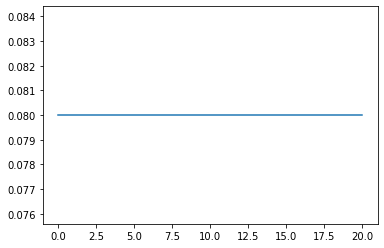

In [489]:
import matplotlib.pyplot as plt
plt.plot([P2_from_p1Pz(ic_cur, score_l2, x) for x in np.linspace(0, 1, 21)])

In [490]:
import numpy as np

def netu(y, x): # 返回残差
    y = y - y.mean()
    x = x - x.mean()
    dy = y - (y * x).sum() / (x * x).sum() * x
    return dy

def cov(x, y):
    return (x * y).mean() - x.mean() * y.mean()
   
def corr(x, y):
    y = y - y.mean()
    x = x - x.mean()
    return (y * x).sum() / (x * x).sum() ** 0.5 / (y * y).sum() ** 0.5

np.random.seed(777)
a = np.random.random(100)
b = np.random.random(100)
c = np.random.random(100) + b * 0.5

In [491]:
a = (a - np.mean(a)) / np.std(a)
b = (b - np.mean(b)) / np.std(b)
c = (c - np.mean(c)) / np.std(c)

In [508]:
corr(b,c)

0.5316974031167164

In [509]:
corr(a, b + c)

0.06521913483970342

In [510]:
p2 = corr(a,a-netu(netu(a, b), netu(c, b)))
p2 # 0.7070330543403667

0.06639470173826845

In [511]:
corr_a_b = corr(a,b)
corr_b_c = corr(b,c)
pc = corr(netu(a, b), c)

# corr_a_b = 0.08
# corr_b_c = 0.99
# pc = 0.02

In [512]:
corr_a_c = pc * ((1 - corr_a_b ** 2) ** 0.5) + corr_a_b * corr_b_c
u = ((0.0 + corr_a_c) / (0.0 + corr_a_b)) ** 2
p2_ = (corr_a_b + u * corr_a_c) / (1 + u ** 2 + 2 * u * corr_b_c) ** 0.5
p2_

0.06621482925296164

In [522]:
(1 + pc) 

1.0359946050048787

In [523]:
(1 + corr_b_c) ** 0.5

1.2376176320320895

In [537]:
pc

0.03599460500487867

In [538]:
(2 * pc) / (1 + (corr_b_c) ** 0.5)

0.04163209340339964

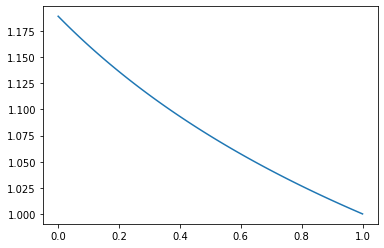

In [546]:
x = np.linspace(0, 1, 101)
y = (2 / (1 + x)) ** 0.25
plt.plot(x, y)

In [543]:
2 * 3 ** 2

18

In [507]:
# for corr_b_c in np.linspace(0, 1, 21):
#     corr_a_c = pc * ((1 - corr_a_b ** 2) ** 0.5) + corr_a_b * corr_b_c
#     u = ((0.0 + corr_a_c) / (0.0 + corr_a_b)) ** 2
#     p2_ = (corr_a_b + u * corr_a_c) / (1 + u ** 2 + 2 * u * corr_b_c) ** 0.5
    
#     print(corr_a_c, corr(a, c), p2_)
#     print()

In [457]:
pc * ((1 - corr_a_b ** 2) ** 0.5), corr_a_b * corr_b_c

(0.035947660364404325, 0.02714639663646507)

In [458]:
corr_a_c

0.0630940570008694

In [435]:
corr_a_b, corr_a_c

(0.05105610160466777, 0.0630940570008694)

In [439]:
pc

0.03599460500487867

In [437]:
corr_a_b * corr_b_c

0.02714639663646507

In [ ]:
corr_a_b, pc, corr_a_c

(0.05105610160466777, 0.0630940570008694)

In [389]:
corr(a, b), corr(a, c)

(0.05105610160466777, 0.06309405700086941)

In [332]:
corr_b_c

0.5772751294656536

-0.07831787838453992

In [240]:
(corr(a, c) - corr(a, b) * corr(b, c)) / (1 - cov(a, b) ** 2) ** 0.5

-0.07831787838454006

In [21]:
p2_ = (p1**2 + corr(a,c)**2 - 2*p1*corr(a,c)*corr(b,c)) ** 0.5 / (1 - corr(b,c) ** 2) ** 0.5
p2_

0.7070330543403669

In [22]:
pc

-0.07831787838453999

In [34]:
y,x,z = a,b,c

In [38]:
pc = corr(y - corr(y, x) * x, z)
pc

-0.07831787838453996

In [39]:
pz = corr(y - corr(y, x) * x, z) #/ (1 - p1 ** 2) ** 0.5
pz

-0.07831787838453996

In [ ]:




pc = (cov(y, z) - p1 * cov(z, x)) / (1 - p1 ** 2) ** 0.5
pc

pz * (1 - p1 ** 2) ** 0.5 + p1 * cov(z, x)

